# MODELING

Requirementts:

    Data meets OLS Assumptions.

    Correctly fit at least 1 model.

    Your model should not include any predictors with p-values greater than .05

Check Model Validity:
- Interpret beta coefficients
- Interpret residuals (are you over/under estimating)
- cross validate with Kfolds
- check predictions
- does this model satisfy the problem?
---------------------
* You provide at least 1 paragraph explaining your final model. 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

%matplotlib inline

In [49]:
def build_sm_ols(df, features_to_use, target, add_constant=False, show_summary=True):
    X = df[features_to_use]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X).fit()
    if show_summary:
        print(ols.summary())
    return ols


def check_vif(df, features_to_use, target_feature):
    ols = build_sm_ols(df=df, features_to_use=features_to_use, target=target_feature, show_summary=False)
    r2 = ols.rsquared
    return 1 / (1 - r2)

def check_vif_feature_space(df, features_to_use,vif_threshold=3.0):
    all_good_vif = True
    for feature in features_to_use:
        target_feature = feature
        _features_to_use = [f for f in features_to_use if f!=target_feature]
        vif = check_vif(df=df, features_to_use=_features_to_use, target_feature=target_feature)
        if vif >= vif_threshold:
            print(f"{target_feature} surpassed threshold with vif={vif}")
            all_good_vif = False
    return all_good_vif

def check_model(df, 
                features_to_use, 
                target_col, 
                add_constant=False, 
                show_summary=False, 
                vif_threshold=3.0):
    has_multicollinearity = check_vif_feature_space(df=df, 
                                                    features_to_use=features_to_use, 
                                                    vif_threshold=vif_threshold)
    if not has_multicollinearity:
        print("Model contains multicollinear features")
    
    # build model 
    ols = build_sm_ols(df=df, features_to_use=features_to_use, 
                       target=target_col, add_constant=add_constant, 
                       show_summary=show_summary)
    
    # check residuals
    resids_are_norm = check_residuals_normal(ols)
    resids_are_homo = check_residuals_homoskedasticity(ols)
    
    if not resids_are_norm or not resids_are_homo:
        print("Residuals failed test/tests")
    return ols

# assumptions of ols
# residuals are normally distributed
def check_residuals_normal(ols):
    residuals = ols.resid
    t, p = stats.shapiro(residuals)
    if p <= 0.05:
        return False
    return True


# residuals are homoskedasticitous
def check_residuals_homoskedasticity(ols):
    import statsmodels.stats.api as sms
    resid = ols.resid
    exog = ols.model.exog
    lg, p, f, fp = sms.het_breuschpagan(resid=resid, exog_het=exog)
    if p >= 0.05:
        return True
    return False

def norm_col(series):
    return (series - series.mean()) / series.std()

def plot_residuals(df, target, features, model):
    y_true = df[target]
    y_pred = model.predict(df[features])
    residuals = model.resid
    
    plt.scatter(y_true, y_pred)
    plt.show()
    
    plt.hist(residuals)
    plt.show()
    
    x_axis = np.linspace(0,1,len(residuals))
    plt.scatter(x_axis, residuals)
    plt.hlines(y=0, xmin=0, xmax=1, color='red')
    plt.show()
    
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title('QQ Plot for residuals MODEL 1')
    plt.show()
    
    return f"Mean residuals $ {round(residuals.abs().mean(),2)}"

def get_train_test_RMSE(df_selected_features, df_target):
    # train/test split at 70/30
    X_train, X_test, y_train, y_test = train_test_split(df_selected_features, df_target, test_size=0.3, random_state=42)
    print("Train/Test Splits:", len(X_train), len(X_test), len(y_train), len(y_test))
    # fit model
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test) 
    # difference in residuals
    train_residuals = np.sum(y_train-y_hat_train)
    test_residuals = np.sum(y_test-y_hat_test)
    print("Difference in residuals:", train_residuals - test_residuals)
    # calculate the MSE for training and test sets:
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    print('Train Mean Squarred Error:', train_mse)
    print('Test Mean Squarred Error:', test_mse)
    print("\n")
    if test_mse > train_mse:
        print("Test MSE is greater, Model Overfit")
    else:
        print("Train MSE is greater, Model Underfit")
    return linreg

def cross_val(linreg, X, y, cv=5):
    mse = make_scorer(mean_squared_error)
    cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
    print("Cross Val. Mean:", cv_5_results.mean())
    return cv_5_results


In [3]:
df = pd.read_csv("../data/kc_house_data_cleaned.csv").drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20287 entries, 0 to 20286
Data columns (total 24 columns):
price                   20287 non-null float64
bedrooms                20287 non-null int64
bathrooms               20287 non-null float64
has_basement            20287 non-null int64
sqft_living             20287 non-null int64
sqft_lot                20287 non-null int64
liv/lot                 20287 non-null float64
view                    20287 non-null float64
age                     20287 non-null int64
age_decade              20287 non-null int64
condition               20287 non-null int64
grade                   20287 non-null int64
reno?                   20287 non-null int64
reno_age                20287 non-null float64
lat                     20287 non-null float64
long                    20287 non-null float64
zipcode                 20287 non-null int64
zipcode_mean_price      20287 non-null float64
zipcode_median_price    20287 non-null float64
zipcode_mode_price

In [4]:
# drop columns that used target = 'price' in calculation; would be too much bias
df.drop(['zipcode_mean_price',
 'zipcode_median_price',
 'zipcode_mode_price'], axis=1, inplace=True)

In [5]:
# calculate a rough score representing distance from center (most expensive area, Bellevue)
# to compare how it fares in the model
top_lat = df.loc[df['price'] == 1450000][['lat', 'long']].mean()[0]
top_long = df.loc[df['price'] == 1450000][['lat', 'long']].mean()[1]

df['dist_cent'] = abs((df['lat'] - top_lat) * (df['long'] - top_long))
df = df.loc[df['dist_cent']<0.1] # drop 55 homes determined to be too far from center in "Where?" notebook

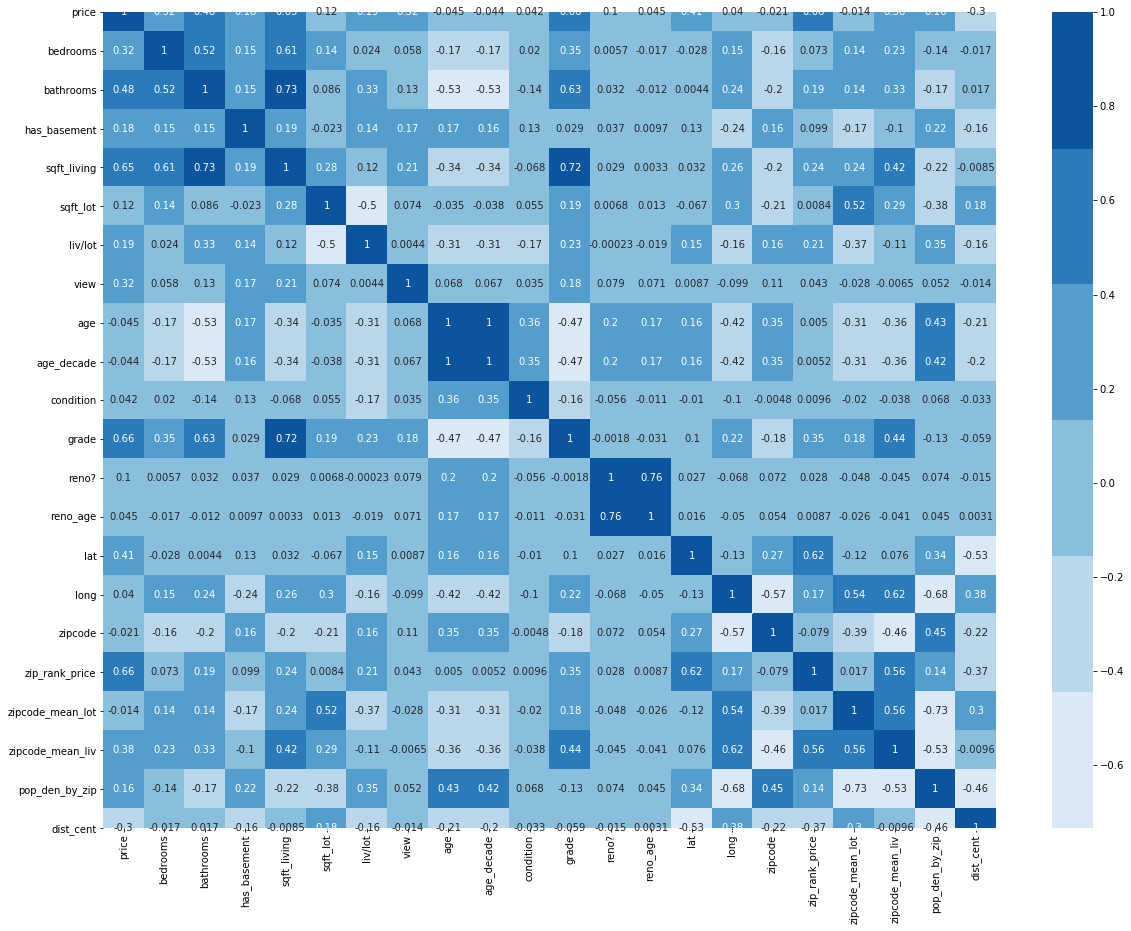

In [6]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap=sns.color_palette('Blues'), fmt='0.2g');

In [7]:
# calculate correlation with target
target = 'price'
correlation_array = []
failed_cols = []
for col in df.drop(target,axis=1).columns:
    try:
        correlation = abs(np.corrcoef(df[col], df[target])[0][1])
        if correlation == correlation:
            correlation_array.append((col, correlation))
        else:
            failed_cols.append(col)
    except:
        failed_cols.append(col)
correlated_features = list(map(lambda x: x[0], correlation_array))
correlation_array = sorted(correlation_array, key=lambda x: x[1], reverse=True)
correlation_array

[('zip_rank_price', 0.6648347844504322),
 ('grade', 0.6562417600561955),
 ('sqft_living', 0.6467980677313286),
 ('bathrooms', 0.475990550397925),
 ('lat', 0.4075651759358827),
 ('zipcode_mean_liv', 0.37647975406021916),
 ('view', 0.31684459562499634),
 ('bedrooms', 0.3167008792999216),
 ('dist_cent', 0.30204140110145206),
 ('liv/lot', 0.1932293148446673),
 ('has_basement', 0.18472517563137994),
 ('pop_den_by_zip', 0.15767140873751592),
 ('sqft_lot', 0.12127270772910517),
 ('reno?', 0.10025550353501664),
 ('reno_age', 0.04542922887573871),
 ('age', 0.0454022863866378),
 ('age_decade', 0.044234317077923836),
 ('condition', 0.042010549126438576),
 ('long', 0.040189294768764997),
 ('zipcode', 0.020540609089422877),
 ('zipcode_mean_lot', 0.014128794480145488)]

In [8]:
# select top 13 correlated features
top_13_corr = list(map(lambda x: x[0], correlation_array[:13]))
top_13_corr

['zip_rank_price',
 'grade',
 'sqft_living',
 'bathrooms',
 'lat',
 'zipcode_mean_liv',
 'view',
 'bedrooms',
 'dist_cent',
 'liv/lot',
 'has_basement',
 'pop_den_by_zip',
 'sqft_lot']

In [9]:
# how are these features correlated with each other?
df_corr=df[top_13_corr].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated 
# with variables other than themselves.
# df_corr.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr[(abs(df_corr.cc)>.5) & (abs(df_corr.cc) <1)]

,cc
pairs,
"(bathrooms, sqft_living)",0.727255
"(sqft_living, bathrooms)",0.727255
"(grade, sqft_living)",0.724521
"(sqft_living, grade)",0.724521
"(bathrooms, grade)",0.628427
"(grade, bathrooms)",0.628427
"(lat, zip_rank_price)",0.622107
"(zip_rank_price, lat)",0.622107
"(sqft_living, bedrooms)",0.611599


In [10]:
# bathrooms, bedrooms deleted; represented by grade and sq_ft living
to_remove = ['bathrooms', 'bedrooms']
df.drop(to_remove, axis=1, inplace=True)
top_11_corr = list(set(top_13_corr).difference(to_remove))

In [11]:
# repeat correlation check
# how are these features correlated with each other?
df_corr=df[top_11_corr].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
# drop duplicates. This could be dangerous if you have variables perfectly correlated 
# with variables other than themselves.
# df_corr.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr[(abs(df_corr.cc)>.5) & (abs(df_corr.cc) <1)]

,cc
pairs,
"(grade, sqft_living)",0.724521
"(sqft_living, grade)",0.724521
"(zip_rank_price, lat)",0.622107
"(lat, zip_rank_price)",0.622107
"(zipcode_mean_liv, zip_rank_price)",0.561868
"(zip_rank_price, zipcode_mean_liv)",0.561868
"(zipcode_mean_liv, pop_den_by_zip)",0.529727
"(pop_den_by_zip, zipcode_mean_liv)",0.529727
"(dist_cent, lat)",0.529057


In [12]:
# this ratio is less correlated with price than its origin columns
to_remove = ['liv/lot']
df.drop(to_remove, axis=1, inplace=True)
top_10_corr = list(set(top_11_corr).difference(to_remove))

In [13]:
top_10_df = df[top_10_corr+['price']]
top_10_df.to_csv("../data/top_10_df.csv")
top_10_corr

['grade',
 'lat',
 'has_basement',
 'sqft_lot',
 'zipcode_mean_liv',
 'sqft_living',
 'dist_cent',
 'view',
 'pop_den_by_zip',
 'zip_rank_price']

In [14]:
# top_10_df = pd.read_csv("../data/top_10_df.csv").drop('Unnamed: 0', axis=1)

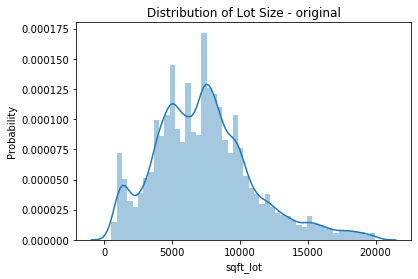

In [15]:
# based on "Where?" investigatitong,
# previous lot distribution by zip, the areas we are interested are below 25,000 sq ft lots
top_10_df = top_10_df.loc[top_10_df['sqft_lot'] < 20000]
sns.distplot(top_10_df['sqft_lot']);
plt.title('Distribution of Lot Size - original')
plt.ylabel('Probability')
plt.show()

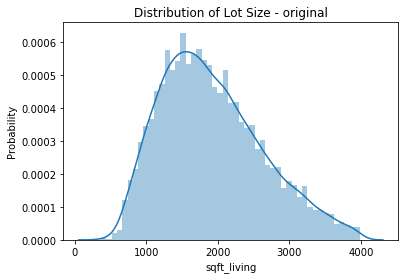

In [16]:
# based on our "Where?" investigation, the areas we are interested in average houses below 5,000 sq ft living space
top_10_df = top_10_df.loc[top_10_df['sqft_living'] < 4000]
sns.distplot(top_10_df['sqft_living']);
plt.title('Distribution of Lot Size - original')
plt.ylabel('Probability')
plt.show()

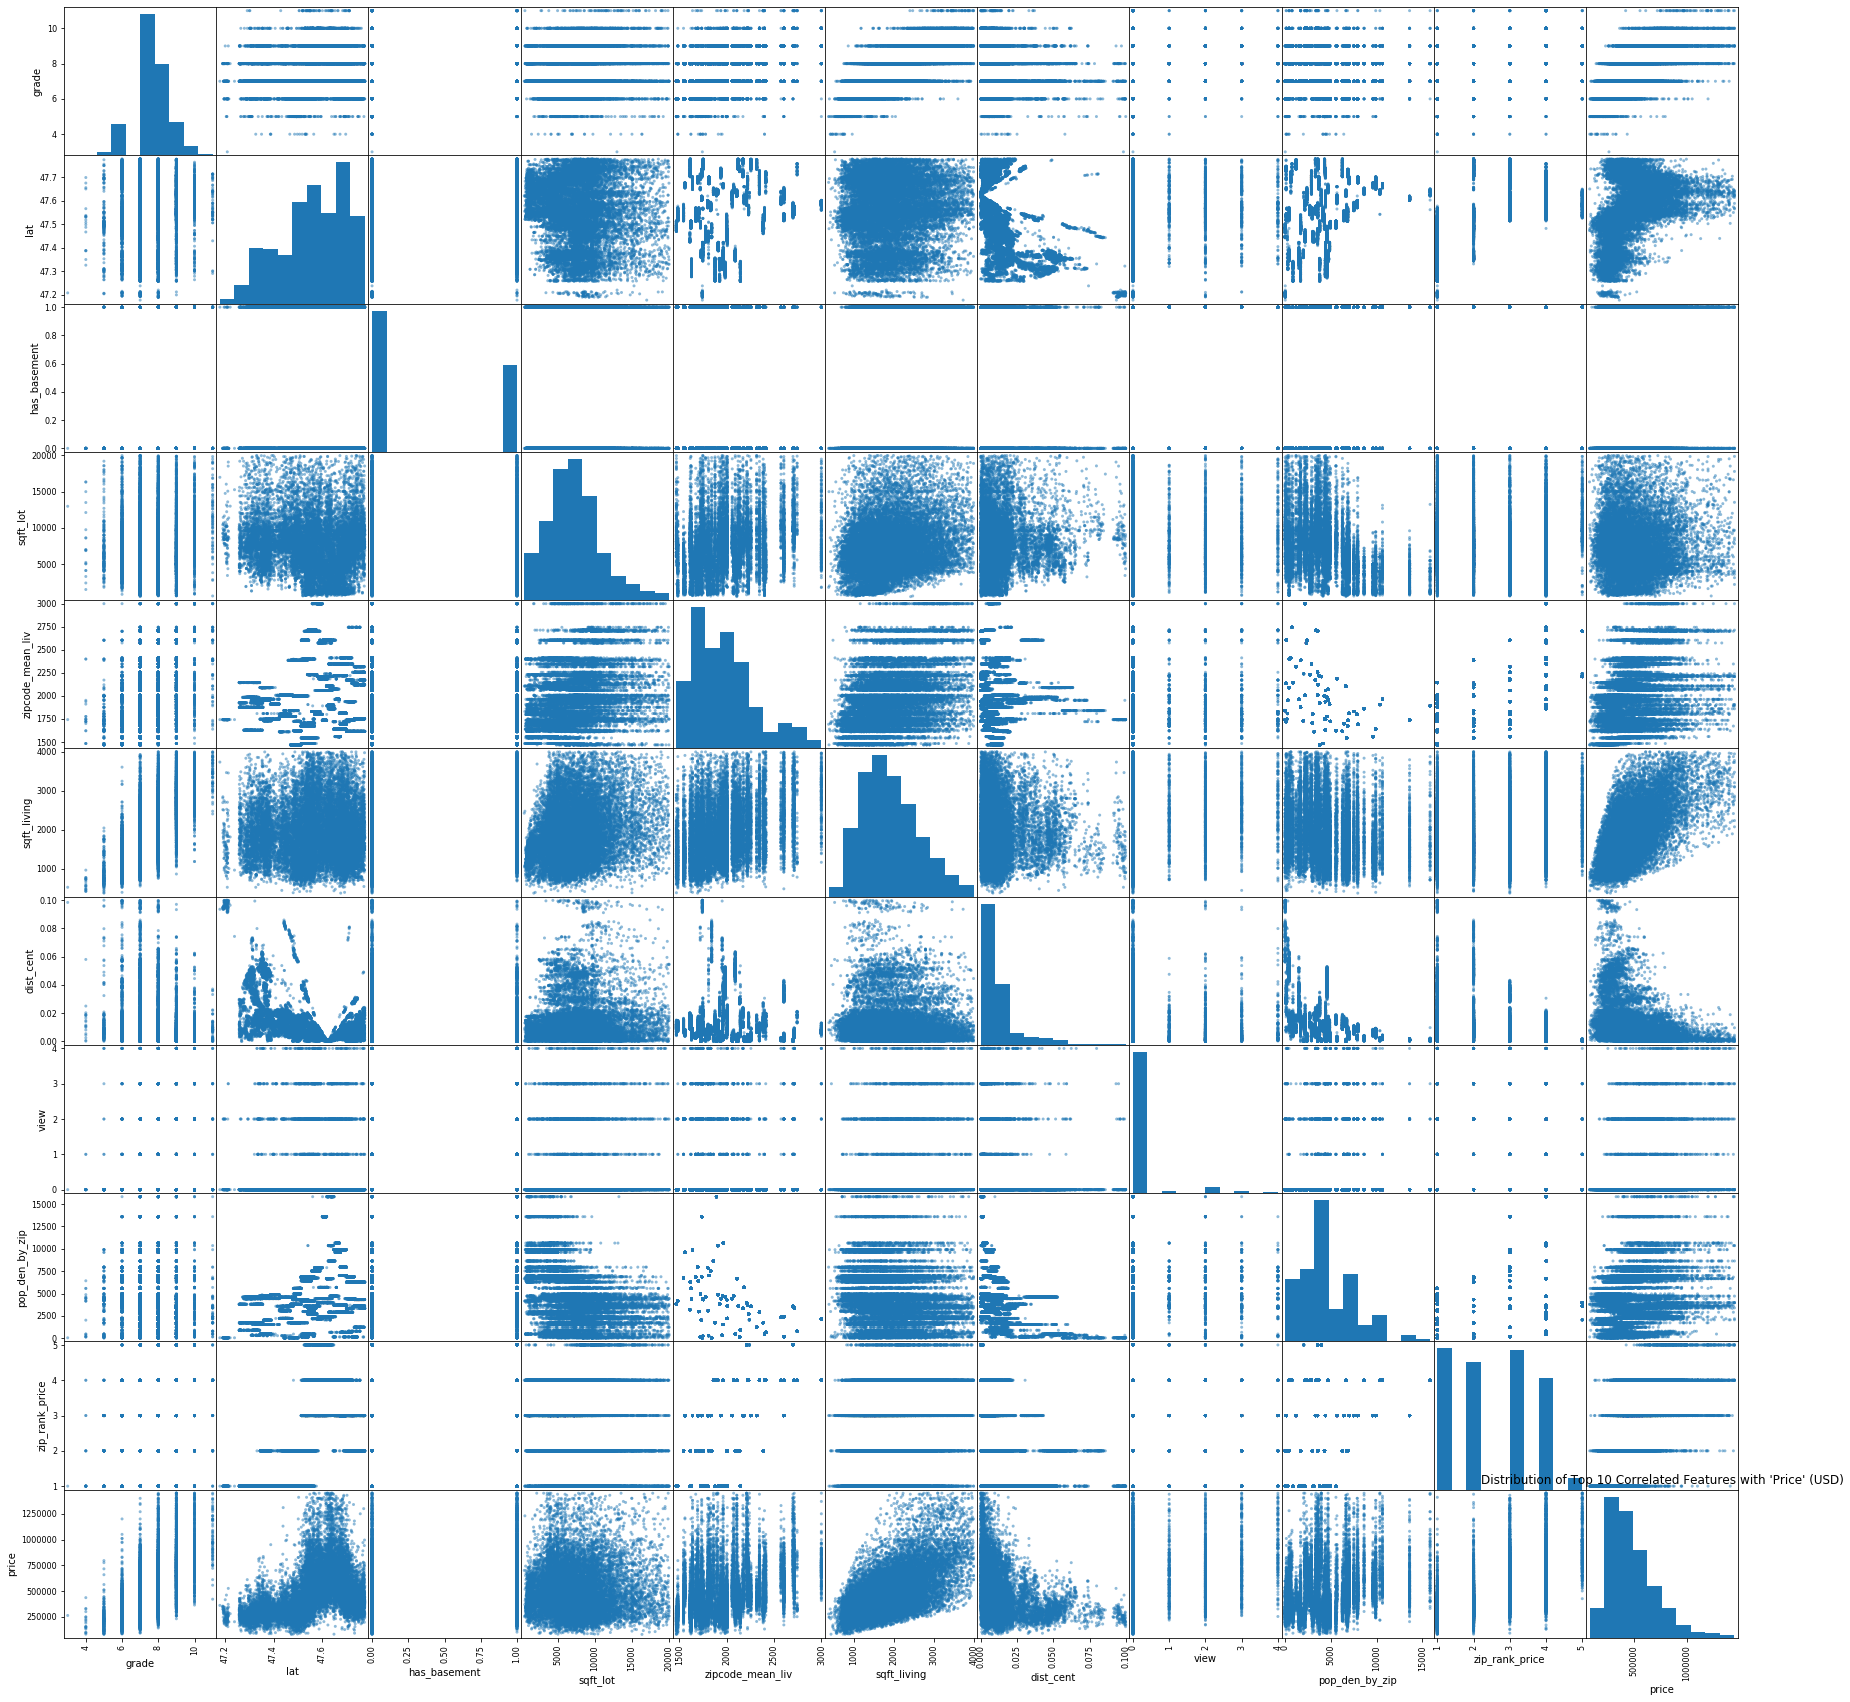

In [17]:
pd.plotting.scatter_matrix(top_10_df, figsize=(30, 30));
plt.title("Distribution of Top 10 Correlated Features with 'Price' (USD)")
plt.show()

In [18]:
# 'has_basement' to be treated as a single col bool
# lat to be left untreated as its a descriptor
# view, zip_rank, zip_mean_liv, pop_density, grade could all be classified as categorical. 
# for the first series of trials, will experiement with running them as numeric to examine if exists a weighted effect


### Log Transform

In [19]:
cols_to_log = ['dist_cent', 'sqft_lot', 'sqft_living']

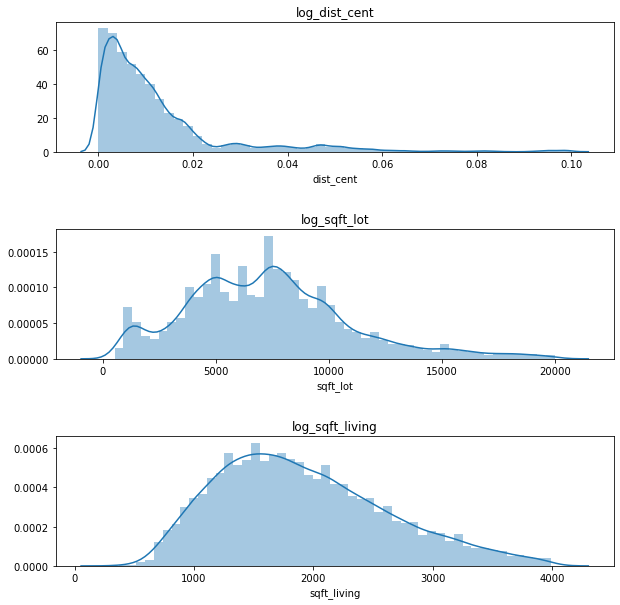

In [20]:
fig, axes = plt.subplots(nrows=len(cols_to_log), ncols=1, figsize=(10,10))
for column, ax in zip(cols_to_log, axes.flatten()):
    top_10_df[column].map(lambda x: np.log(x))
    sns.distplot(top_10_df[column], label=f"log_{column}", ax=ax)
    top_10_df.rename({column: (f"log_"+column)}, axis=1, inplace=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    ax.set_title((f"log_"+column))

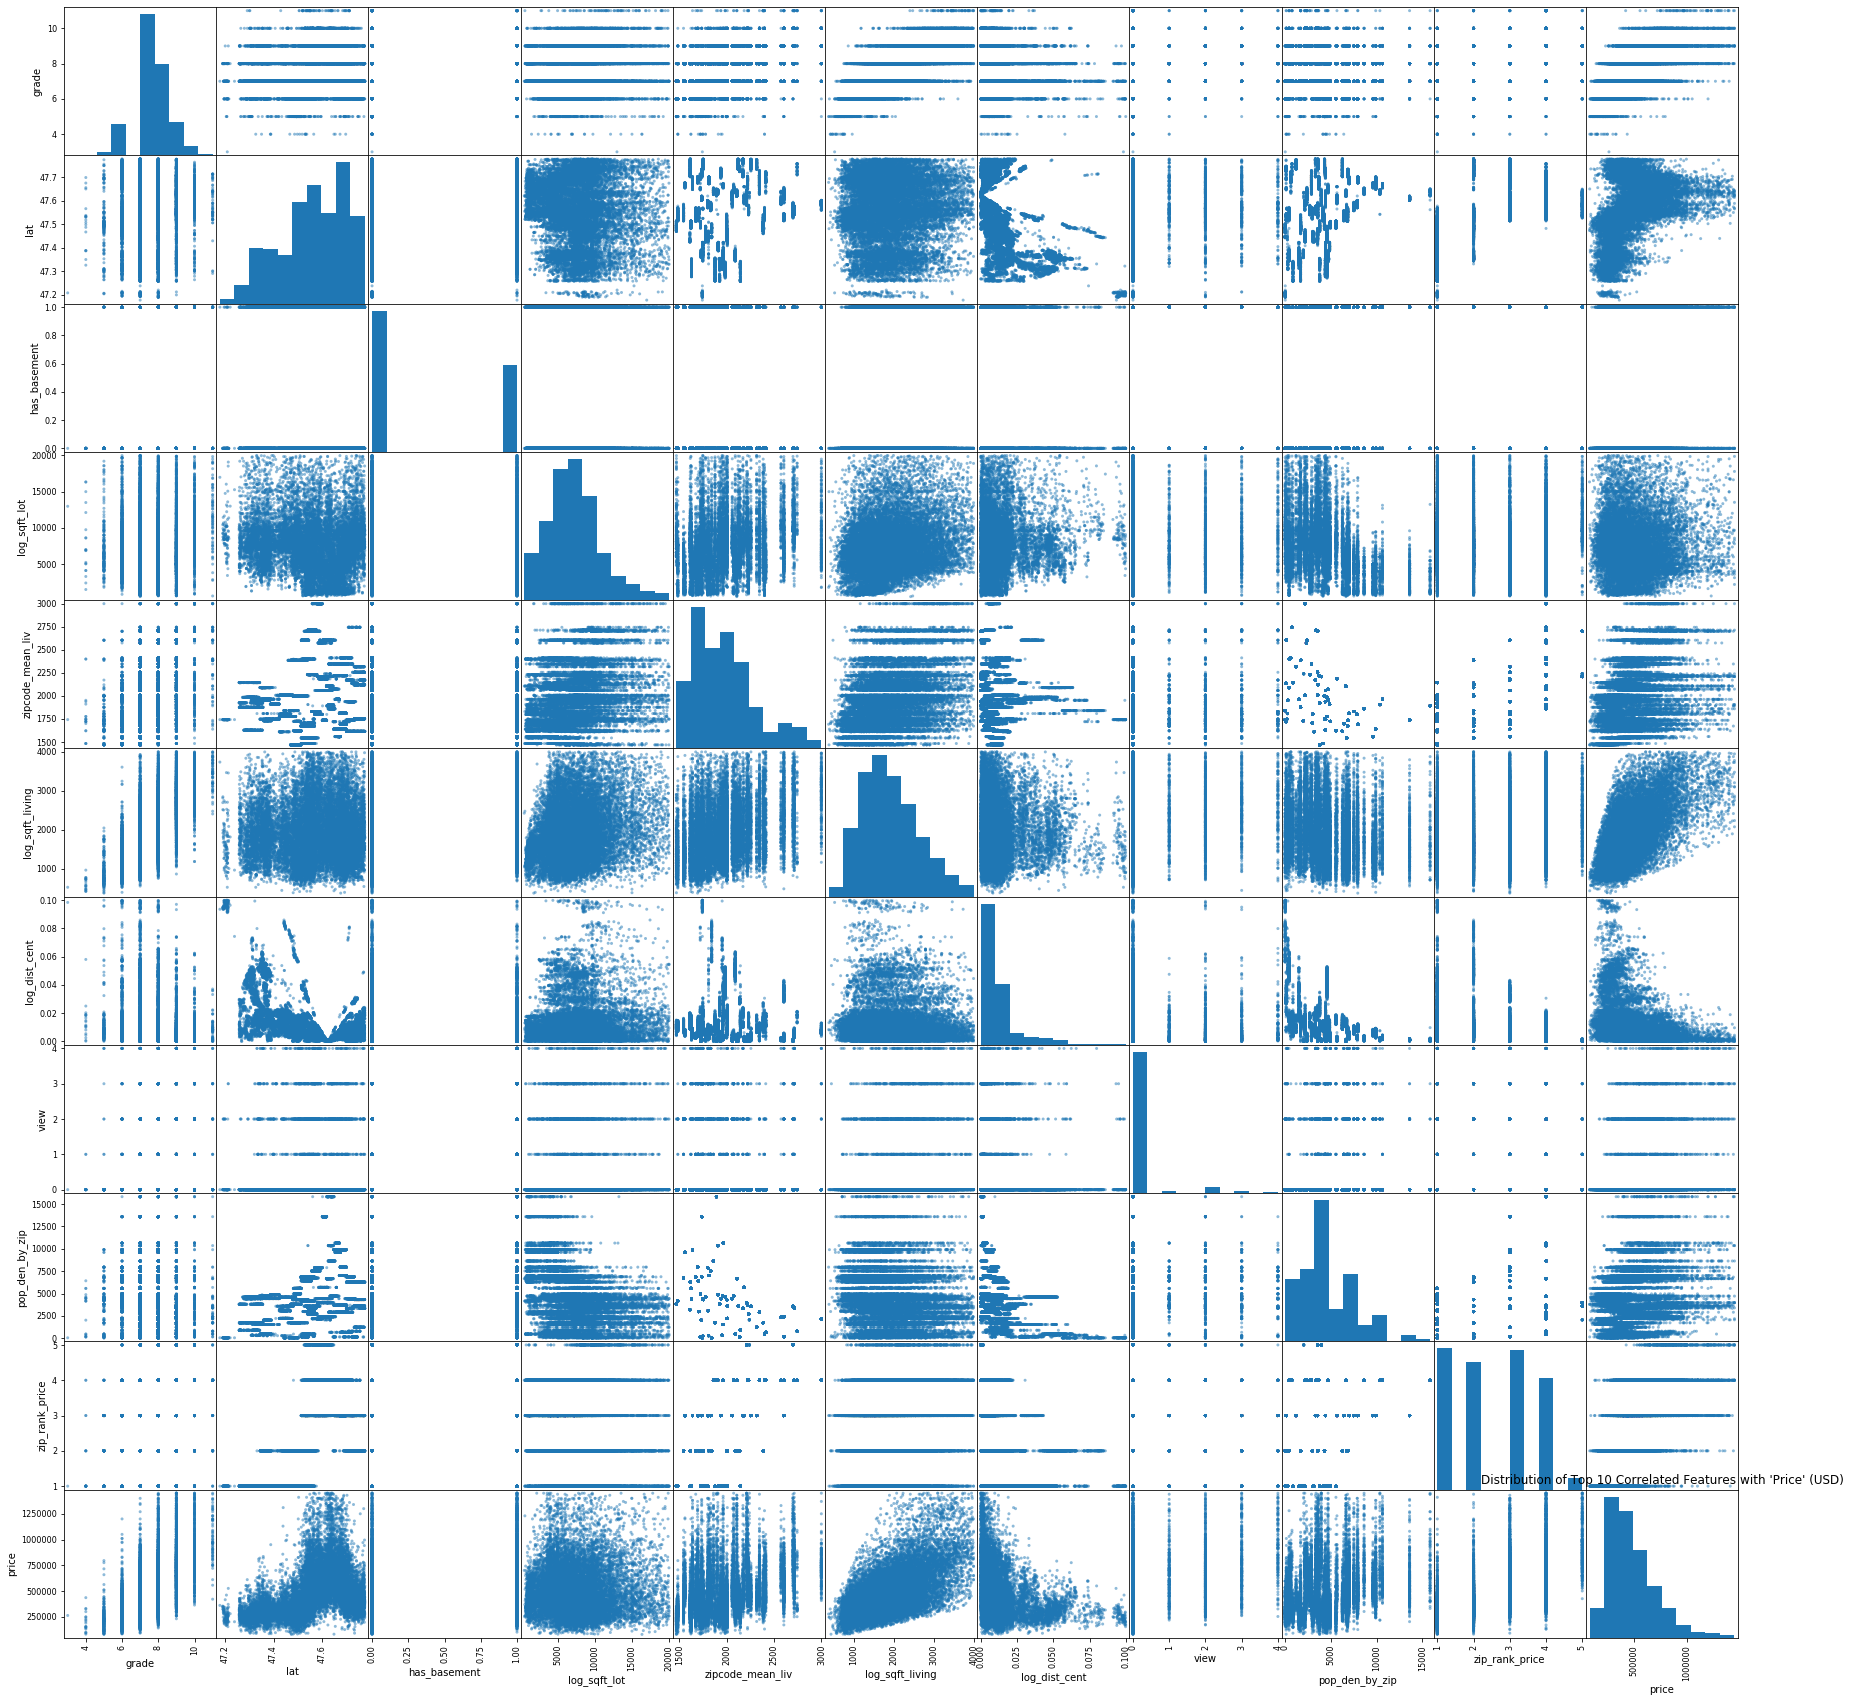

In [21]:
pd.plotting.scatter_matrix(top_10_df, figsize=(30, 30));
plt.title("Distribution of Top 10 Correlated Features with 'Price' (USD)")
plt.show()

### Standardize

#### For Series 1: 
Treating cat columns as continuous, because there is a believed weight to the values. Series 1 uses 'df1' going forward to keep 'top_10_df' same.

In [22]:
df1 = top_10_df
features1 = list(df1.columns)[:-1] # pop off last item, ttarget = 'price'
features1

['grade',
 'lat',
 'has_basement',
 'log_sqft_lot',
 'zipcode_mean_liv',
 'log_sqft_living',
 'log_dist_cent',
 'view',
 'pop_den_by_zip',
 'zip_rank_price']

In [23]:
cols_to_stnrd = ['view',
 'zipcode_mean_liv',
 'log_dist_cent',
 'grade',
 'log_sqft_living',
 'lat',
 'log_sqft_lot',
 'pop_den_by_zip']

for column in cols_to_stnrd:
    df1[column] = norm_col(df1[column])

df1.head()

,grade,lat,has_basement,log_sqft_lot,zipcode_mean_liv,log_sqft_living,log_dist_cent,view,pop_den_by_zip,zip_rank_price,price
0,-0.493634,-0.370912,0,-0.459213,-0.768268,-1.037627,-0.642385,-0.267061,0.118651,1,221900.0
1,-0.493634,1.164594,1,-0.021501,-0.729294,0.925119,-0.264876,-0.267061,0.773340,2,538000.0
2,-1.503655,1.288283,0,0.736795,0.448536,-1.616567,-0.829605,-0.267061,-0.346784,2,180000.0
3,-0.493634,-0.300651,1,-0.637927,-0.839873,0.063770,0.311391,-0.267061,0.617967,3,604000.0
4,0.516386,0.401964,0,0.208902,1.929180,-0.331603,-0.741604,-0.267061,-0.755751,4,510000.0


In [24]:
# repeat correlation check
# how are these features correlated with each other?
df_corr2=df1[features1].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr2['pairs'] = list(zip(df_corr2.level_0, df_corr2.level_1))
df_corr2.set_index(['pairs'], inplace = True)
df_corr2.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr2.columns = ['cc']
df_corr2.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr2[(abs(df_corr2.cc)>.5) & (abs(df_corr2.cc) <1)]

,cc
pairs,
"(grade, log_sqft_living)",0.685662
"(zip_rank_price, lat)",0.622872
"(zipcode_mean_liv, zip_rank_price)",0.538200
"(log_dist_cent, lat)",0.535703
"(zipcode_mean_liv, pop_den_by_zip)",0.526979


Grade and sqft_living are highly correlated. Let's try two seperate feature spaces for each. 'lat' information is represented both in zip_mean_rank and log_dist_center. lets try dropping it.

## Build Models

### Series 1: Grade

#### Trial 1

In [25]:
grade_features1 = list(set(features1).difference(['log_sqft_living', 'lat']))
grade_features1

['log_dist_cent',
 'grade',
 'has_basement',
 'zipcode_mean_liv',
 'log_sqft_lot',
 'view',
 'pop_den_by_zip',
 'zip_rank_price']

In [26]:
check_vif_feature_space(df1, grade_features1)

True

In [27]:
model1 = build_sm_ols(df1, grade_features1, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                          3.425e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        23:49:56   Log-Likelihood:                     -2.4540e+05
No. Observations:               18556   AIC:                                  4.908e+05
Df Residuals:                   18548   BIC:                                  4.909e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

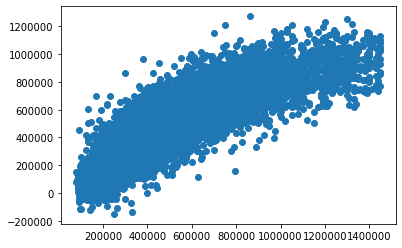

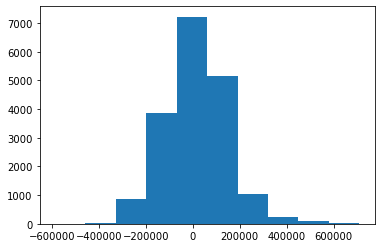

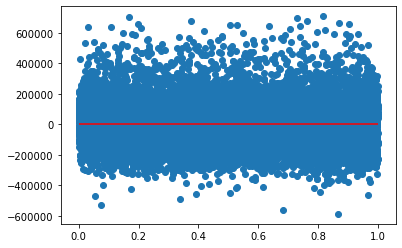

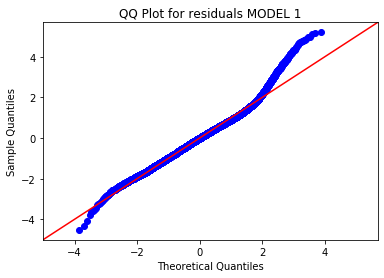

'Mean residuals $ 103453.23'

In [39]:
plot_residuals(df1, target, grade_features1, model1)

VIF CHECK: True
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.467
Model:                            OLS   Adj. R-squared (uncentered):              0.467
Method:                 Least Squares   F-statistic:                              2712.
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:05:11   Log-Likelihood:                     -2.6515e+05
No. Observations:               18556   AIC:                                  5.303e+05
Df Residuals:                   18550   BIC:                                  5.304e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

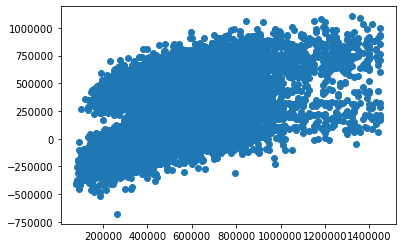

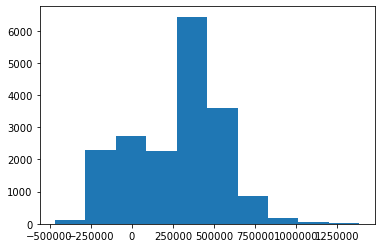

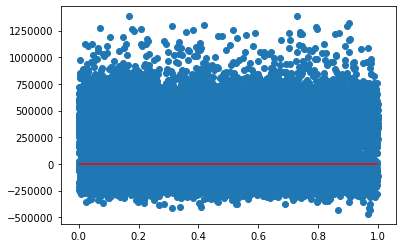

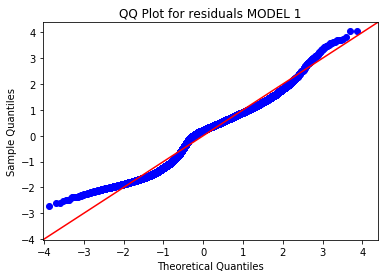

'Mean residuals $ 331581.78'

In [56]:
#experiemnt
ex_features = ['log_dist_cent',
 'grade',
 'has_basement',
 'zipcode_mean_liv',
 'log_sqft_lot',
 'view'] 
print("VIF CHECK:", check_vif_feature_space(df1, ex_features))
model4 = build_sm_ols(df1, ex_features, target, add_constant=False, show_summary=True)
plot_residuals(df1, target, ex_features, model4)

### Series 2: Sq Ft Living
#### Trial 1

In [61]:
sqliv_features1 = list(set(features1).difference(['grade', 'lat']))
sqliv_features1

['log_dist_cent',
 'has_basement',
 'zipcode_mean_liv',
 'log_sqft_lot',
 'log_sqft_living',
 'view',
 'pop_den_by_zip',
 'zip_rank_price']

In [62]:
check_vif_feature_space(df1, sqliv_features1)

True

In [63]:
model2 = build_sm_ols(df1, sqliv_features1, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                          4.125e+04
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:07:56   Log-Likelihood:                     -2.4378e+05
No. Observations:               18556   AIC:                                  4.876e+05
Df Residuals:                   18548   BIC:                                  4.876e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

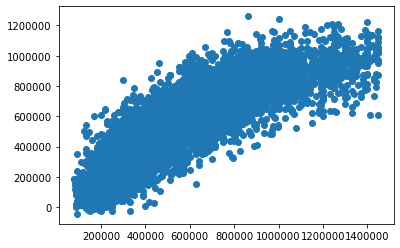

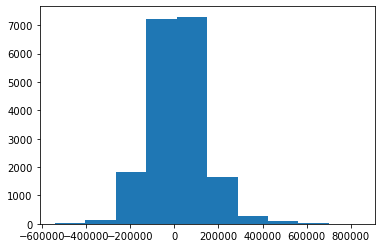

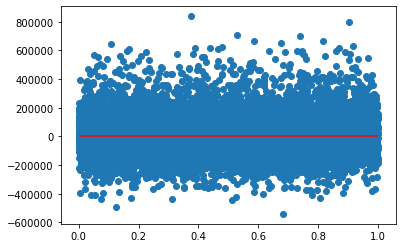

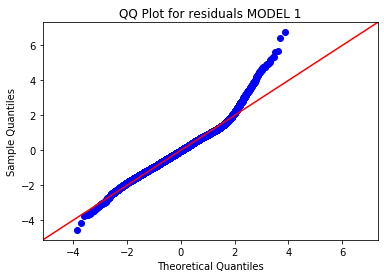

'Mean residuals $ 94189.32'

In [64]:
plot_residuals(df1, target, sqliv_features1, model2)

Mean residuals slightly less, however distribution of errors much more peaky.
#### Trial 2

In [51]:
sqliv_features2 = list(set(sqliv_features1).difference(['zipcode_mean_liv']))
check_vif_feature_space(df1, sqliv_features2)

True

In [34]:
model3 = build_sm_ols(df1, sqliv_features2, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                          3.620e+04
Date:                Tue, 13 Oct 2020   Prob (F-statistic):                        0.00
Time:                        23:51:45   Log-Likelihood:                     -2.4608e+05
No. Observations:               18556   AIC:                                  4.922e+05
Df Residuals:                   18549   BIC:                                  4.922e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

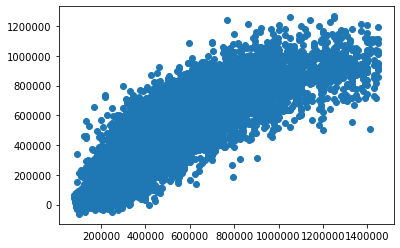

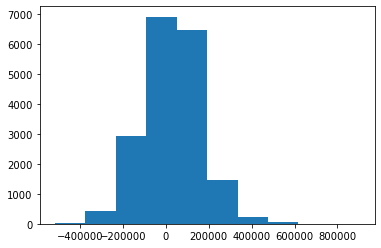

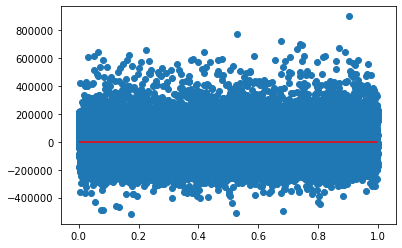

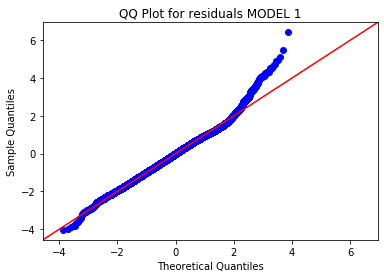

'Mean residuals $ 109452.29'

In [38]:
plot_residuals(df1, target, sqliv_features2, model3)

Mean residuals went up. 

VIF CHECK: True
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.928
Method:                 Least Squares   F-statistic:                          3.958e+04
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        00:00:49   Log-Likelihood:                     -2.4664e+05
No. Observations:               18556   AIC:                                  4.933e+05
Df Residuals:                   18550   BIC:                                  4.933e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

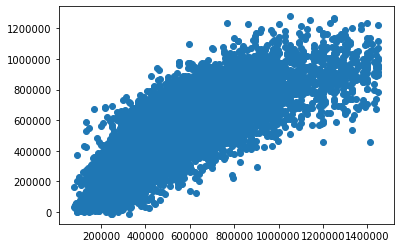

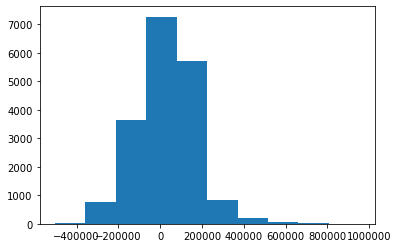

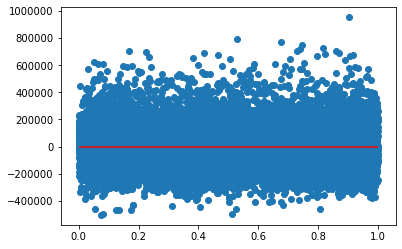

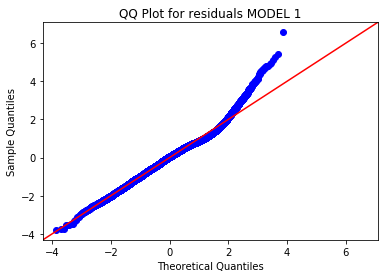

'Mean residuals $ 112421.33'

In [53]:
# experiment zone
sqliv_features3 = list(set(sqliv_features2).difference(['pop_den_by_zip']))
print("VIF CHECK:", check_vif_feature_space(df1, sqliv_features3))
model4 = build_sm_ols(df1, sqliv_features3, target, add_constant=False, show_summary=True)
plot_residuals(df1, target, sqliv_features3, model4)

#### Train/Test Split

In [50]:
selected_feat = sqliv_features2
X = df1[selected_feat]
y = df1[target]

linreg = get_train_test_RMSE(X, y)

Train/Test Splits: 12989 5567 12989 5567
Difference in residuals: 10572358.133004699
Train Mean Squarred Error: 12424521178.804379
Test Mean Squarred Error: 12737345306.022367


Test MSE is greater, Model Overfit


#### Cross Validate

In [48]:
cross_val(linreg, X, y)

Cross Val. Mean: 12557289191.49945


array([1.30150781e+10, 1.25714139e+10, 1.25200352e+10, 1.23614231e+10,
       1.23184955e+10])

### Summary


Ehhhh